# Analysis of global results

In [18]:
from evaluation_utils import create_encoder_latex_table, unpivot_baseline_model, unpivot_ssl_model, read_multiple_global_results, ssl_method_to_category
from constants import MODE_1_PROCESSED_DIR, MODE_2_3_PROCESSED_DIR, TEST_METRIC, ENCODERS, TRAINING_SCHEMES, SSL_MODELS, BASELINES, AUXILIARY_ALL,\
    CONTRAST_ALL, HYBRID_ALL, GENERATION_ALL, BASELINES, model_abbreviations, FONT,\
    GENERATION_BASED_CATEGORY, HYBRID_CATEGORY, CONTRAST_BASED, AUXILIARY_CATEGORY, ENCODER_COLORS
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import matplotlib.gridspec as gridspec
from matplotlib.lines import Line2D

plt.rcParams["font.family"] = FONT

In [2]:
# Mode 1 and 2/3 raw
data = read_multiple_global_results(experiments=[
    ('Mode 1', MODE_1_PROCESSED_DIR),
    ('Mode 2/3', MODE_2_3_PROCESSED_DIR)
])

# SSL results
df_ssl = unpivot_ssl_model(df=data, suffix=TEST_METRIC, ssl_models=SSL_MODELS, encoders=ENCODERS, training_schemes=TRAINING_SCHEMES)
df_baseline = unpivot_baseline_model(df=data, suffix=TEST_METRIC, baseline_models=BASELINES, training_schemes=TRAINING_SCHEMES)

1.ndjson
2.ndjson
3.ndjson
4.ndjson
5.ndjson
6.ndjson
7.ndjson
8.ndjson
9.ndjson
10.ndjson
11.ndjson
concatenating
1.ndjson
2.ndjson
3.ndjson
4.ndjson
5.ndjson
6.ndjson
7.ndjson
8.ndjson
9.ndjson
10.ndjson
11.ndjson
12.ndjson
13.ndjson
14.ndjson
15.ndjson
16.ndjson
concatenating


# 

In [3]:
df_ssl = df_ssl.astype({
    'train_pretext_weight': 'category'
})

In [29]:
import pandas as pd


grouped_means = df_ssl[df_ssl.Experiment == 'Mode 2/3'].groupby(['Encoder', 'Training_scheme', 'SSL_model'])[TEST_METRIC].mean().reset_index()
grouped_means['SSL_category'] = grouped_means['SSL_model'].apply(ssl_method_to_category)

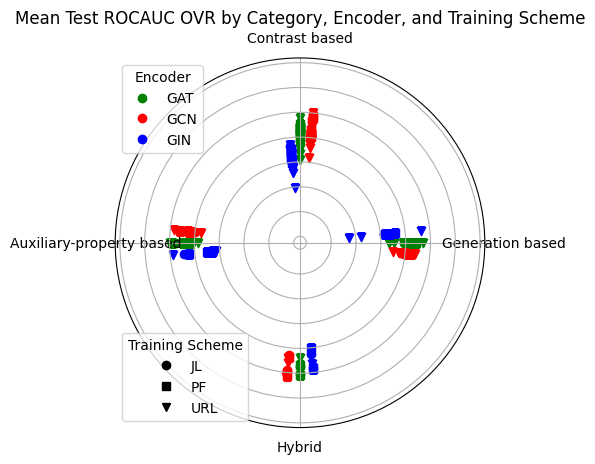

In [44]:
import numpy as np
import matplotlib.pyplot as plt

# Define unique categories, encoders, and training schemes
unique_categories = grouped_means['SSL_category'].unique()
unique_encoders = grouped_means['Encoder'].unique()
unique_training_schemes = grouped_means['Training_scheme'].unique()

# Assign markers to training schemes
training_scheme_markers = {scheme: marker for scheme, marker in zip(unique_training_schemes, ['o', 's', 'v'])}

# Set up the polar plot
fig, ax = plt.subplots(subplot_kw={'polar': True})
ax.set_ylim(grouped_means[TEST_METRIC].min() - 0.1, grouped_means[TEST_METRIC].max() + 0.1)
theta_offset = 2 * np.pi / len(unique_categories)
encoder_offsets = { 'GCN': -0.1, 'GAT': 0, 'GIN': 0.1 }

for category_idx, category in enumerate(unique_categories):
    category_data = grouped_means[grouped_means['SSL_category'] == category]
    
    for _, row in category_data.iterrows():
        
        r = row['test_rocauc_ovr']
        encoder = row['Encoder']
        training_scheme = row['Training_scheme']
        
        theta = category_idx * theta_offset + encoder_offsets[encoder]
        ax.scatter(theta, r, c=ENCODER_COLORS[encoder], marker=training_scheme_markers[training_scheme], label=f"{encoder} {training_scheme}")



# Customize polar plot
ax.set_xticks(np.arange(0, 2 * np.pi, theta_offset))
ax.set_xticklabels(unique_categories)
ax.set_yticklabels([])  # Remove radial ticks
ax.set_rlabel_position(-30)  # Move radial labels to avoid overlapping with data points
ax.set_title('Mean Test ROCAUC OVR by Category, Encoder, and Training Scheme')

# Create custom legend for encoders and training schemes
encoder_legend = [plt.Line2D([0], [0], linestyle='none', marker='o', color=ENCODER_COLORS[encoder]) for encoder in unique_encoders]
scheme_legend = [plt.Line2D([0], [0], linestyle='none', marker=training_scheme_markers[scheme], color='black') for scheme in unique_training_schemes]

legend1 = plt.legend(encoder_legend, unique_encoders, title='Encoder', loc='upper left')
legend2 = plt.legend(scheme_legend, unique_training_schemes, title='Training Scheme', loc='lower left')
ax.add_artist(legend1)  # Add the first legend back, since the second one replaces it by default

plt.show()


# Overall model results in each mode

In [45]:
all_models_cols = [TEST_METRIC, 'Graph_ID', 'Experiment']
all_models_df = pd.concat([
    df_ssl.loc[:, all_models_cols + ['SSL_model']].rename(columns={ 'SSL_model': 'Model' }),
    df_baseline.loc[:, all_models_cols + ['Baseline_model']].rename(columns={ 'Baseline_model': 'Model' })
], ignore_index=True)

mode_1_rankings = (
    all_models_df[all_models_df.Experiment == 'Mode 1']
    .groupby('Model')[TEST_METRIC]
    .mean()
    .rank(ascending=False, method='min')
    .reset_index()
    .rename(columns={ TEST_METRIC: 'Mode 1 rank'})
    .astype({ 'Mode 1 rank': int })
)
mode_2_3_rankings = (
    all_models_df[all_models_df.Experiment == 'Mode 2/3']
    .groupby('Model')[TEST_METRIC]
    .mean()
    .rank(ascending=False, method='min')
    .reset_index()
    .rename(columns={ TEST_METRIC: 'Mode 2/3 rank'})
    .astype({ 'Mode 2/3 rank': int })
)
all_models_df = (
    all_models_df
    .pipe(pd.merge, right=mode_1_rankings, on='Model')
    .pipe(pd.merge, right=mode_2_3_rankings, on='Model')
)

all_models_df = all_models_df.astype({
    'Model': 'category',
    'Experiment': 'category'
})

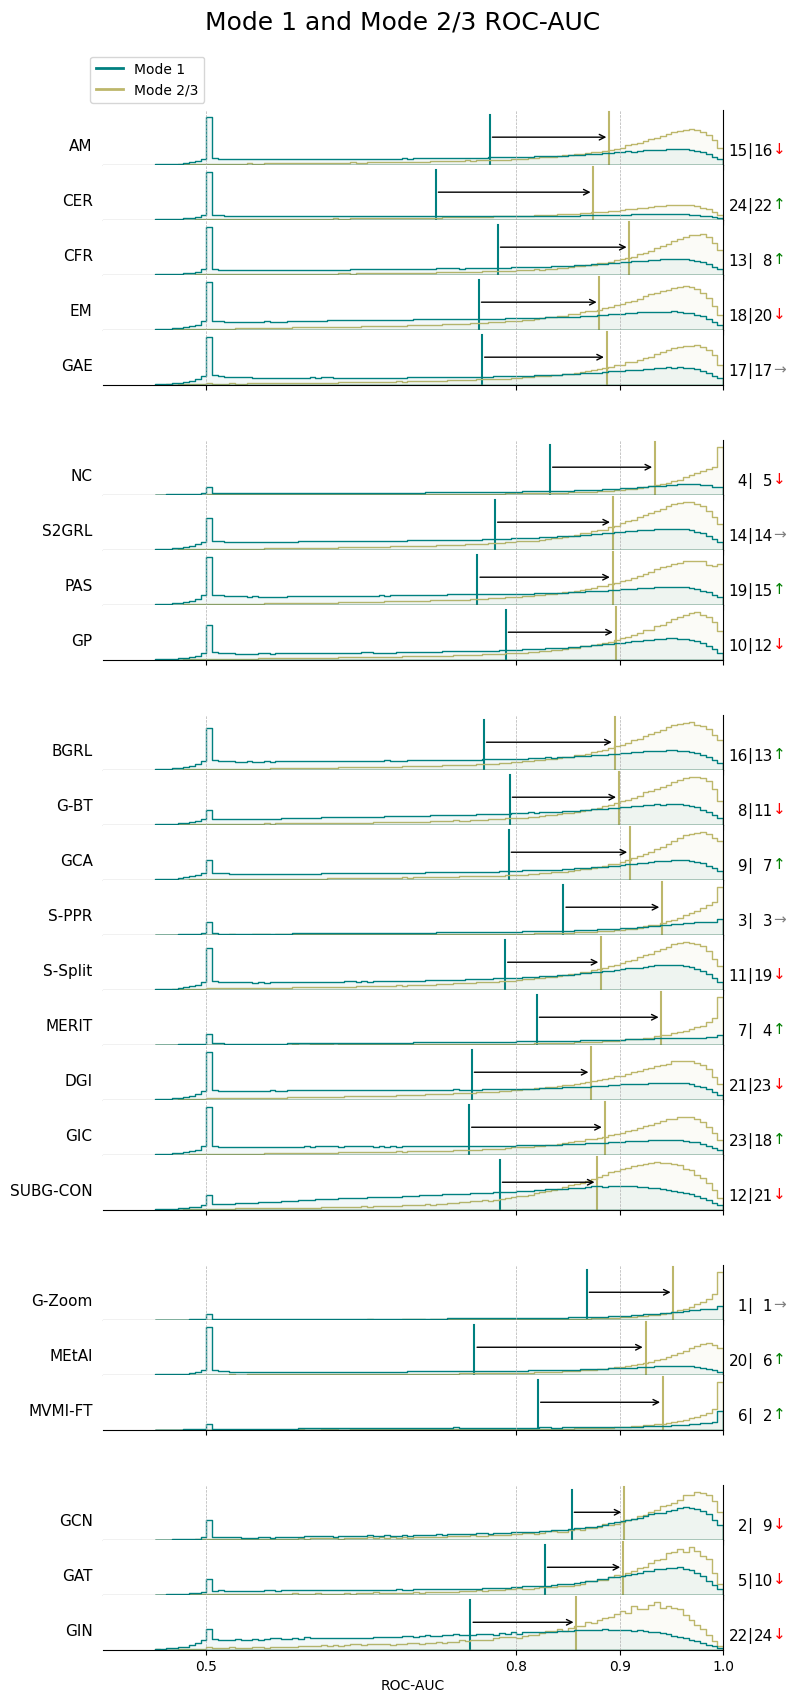

In [5]:
df = all_models_df
color_palette = { 'Mode 1': 'darkkhaki', 'Mode 2/3': 'teal' }

models_with_positions = GENERATION_ALL + AUXILIARY_ALL + CONTRAST_ALL + HYBRID_ALL + BASELINES
bins = np.linspace(0.45, 1.0, num=100)
n_rows = len(models_with_positions) + 4

fig = plt.figure(figsize=(8, 20))
outer = gridspec.GridSpec(nrows=n_rows, ncols=1, hspace=0.002)
color_map = { 'Mode 1': 'teal', 'Mode 2/3': 'darkkhaki' }

legend_elements = [
    Line2D([0], [0], color=color_map['Mode 1'], lw=2, label='Mode 1'),
    Line2D([0], [0], color=color_map['Mode 2/3'], lw=2, label='Mode 2/3')
]
fig.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(0.1, 0.91))
fig.suptitle('Mode 1 and Mode 2/3 ROC-AUC', fontsize=18, y=0.93)


cur_idx = -1
axes = []
for models_in_category in [GENERATION_ALL, AUXILIARY_ALL, CONTRAST_ALL, HYBRID_ALL, BASELINES]:
    cur_idx += 1
    for model_idx, model in enumerate(models_in_category):
        ax = plt.Subplot(fig, outer[cur_idx])
        axes += [ax]
        model_data = df[df['Model'] == model]
        sns.histplot(model_data, x=TEST_METRIC, hue='Experiment', 
                     stat='percent', common_norm=False, 
                     element='step', fill=True, 
                     alpha=0.05, bins=bins,
                     palette=color_map,
                     ax=ax)
        
        means = model_data.groupby('Experiment')[TEST_METRIC].mean()
        maxs = model_data.groupby('Experiment')[TEST_METRIC].max()

        # Dashed line for the mean
        # ax.plot([means.loc['Mode 1']] * 2, [0, ax.get_ylim()[1]], color=color_map['Mode 1'], linestyle='--', zorder=0)
        # ax.plot([means.loc['Mode 2/3']] * 2, [0, ax.get_ylim()[1]], color=color_map['Mode 2/3'], linestyle='--', zorder=0)

        # Non dashed line for the mean
        ax.plot([means.loc['Mode 1']] * 2, [0, ax.get_ylim()[1]], color=color_map['Mode 1'], zorder=0)
        ax.plot([means.loc['Mode 2/3']] * 2, [0, ax.get_ylim()[1]], color=color_map['Mode 2/3'], zorder=0)

        ax.annotate("", xy=(means.loc['Mode 2/3'], ax.get_ylim()[1] / 2), 
            xytext=(means.loc['Mode 1'], ax.get_ylim()[1] / 2),
            arrowprops=dict(facecolor='purple', edgecolor='black', arrowstyle='->'))


        # Bar for the mean
        # ax.bar(means.loc['Mode 1'], ax.get_ylim()[1], color=color_map['Mode 1'], width=0.005, align='center', zorder=0, alpha=0.6)
        # ax.bar(means.loc['Mode 2/3'], ax.get_ylim()[1], color=color_map['Mode 2/3'], width=0.005, align='center', zorder=0, alpha=0.6)

        # Triangle and circle
        # ax.plot(means.loc['Mode 1'], ax.get_ylim()[1] / 2, marker='o', markersize=8, color=color_map['Mode 1'], linestyle='', zorder=3)
        # ax.plot(means.loc['Mode 2/3'], ax.get_ylim()[1] / 2, marker='^', markersize=8, color=color_map['Mode 2/3'], linestyle='', zorder=3)

        # Annotation for the mean
        # ax.annotate(f"Mode 1 Mean: {means.loc['Mode 1']:.3f}", xy=(means.loc['Mode 1'], ax.get_ylim()[1] * 0.9), fontsize=8, color=color_map['Mode 1'], ha='center', va='center')
        # ax.annotate(f"Mode 2/3 Mean: {means.loc['Mode 2/3']:.3f}", xy=(means.loc['Mode 2/3'], ax.get_ylim()[1] * 0.8), fontsize=8, color=color_map['Mode 2/3'], ha='center', va='center')

        # Shaded region
        # ax.axvspan(means.loc['Mode 1'] - 0.01, means.loc['Mode 1'] + 0.01, color=color_map['Mode 1'], alpha=0.3, zorder=1)
        # ax.axvspan(means.loc['Mode 2/3'] - 0.01, means.loc['Mode 2/3'] + 0.01, color=color_map['Mode 2/3'], alpha=0.3, zorder=1)



        ylabel = ax.set_ylabel(model)
        ylabel = ax.set_ylabel(model_abbreviations[model], rotation=0, size=11, ha='right')
        ylabel.set_position((-.1, .2))


    
        # Add rank        
        mode1_rank = model_data.iloc[0]['Mode 1 rank']
        mode23_rank = model_data.iloc[0]['Mode 2/3 rank']        
        mode1_rank_x, rank_y = 1.04, .25
        rank_props = { 'xycoords': 'axes fraction', 'fontsize': 11, 'ha': 'right', 'va': 'center'}

        ax.annotate(f"{mode1_rank:2}", xy=(mode1_rank_x, rank_y), **rank_props)
        ax.annotate('|', xy=(mode1_rank_x + .007, rank_y), **rank_props)
        ax.annotate(f"{mode23_rank:2}", xy=(mode1_rank_x + .04, rank_y), **rank_props)


        if mode1_rank > mode23_rank:
            arrow_direction = u'\u2191'
            arrow_color = 'green'
        elif mode23_rank > mode1_rank :
            arrow_direction = u'\u2193'
            arrow_color = 'red'
        else:
            arrow_direction = u'\u2192'
            arrow_color = 'gray'

        ax.annotate(arrow_direction, xy=(1.04, .2), xycoords="axes fraction", xytext=(1.08, 0.20),
                    textcoords="axes fraction", fontsize=11, color=arrow_color)


        ax.get_legend().remove()
        ax.yaxis.set_ticks([])
        ax.yaxis.set_ticklabels([])
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(True)
        ax.spines['left'].set_visible(False)
        ax.xaxis.grid(True, linestyle='--', linewidth=0.5)
        ax.set_xlim([0.4, 1.0])
        axes[-1].set_xticks([0.5, 0.8, 0.9, 1])
        cur_idx += 1

        if cur_idx < n_rows:
            ax.set_xlabel('')
            ax.set_xticklabels([])

        fig.add_subplot(ax)

axes[-1].set_xlabel('ROC-AUC')
axes[0].annotate('', xy=(0, -0.1), xycoords='axes fraction', xytext=(1, -0.1), 
            arrowprops=dict(arrowstyle="<->", color='b'))
fig.canvas.draw()

# Pretext Weight

In [47]:
df_ssl_mode1 = df_ssl[df_ssl.Experiment == 'Mode 1']
df_ssl_jl = df_ssl_mode1[df_ssl_mode1.Training_scheme == 'JL']

/tmp/ipykernel_46945/1557843902.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ssl_jl.train_pretext_weight = df_ssl_jl.train_pretext_weight.astype(int)


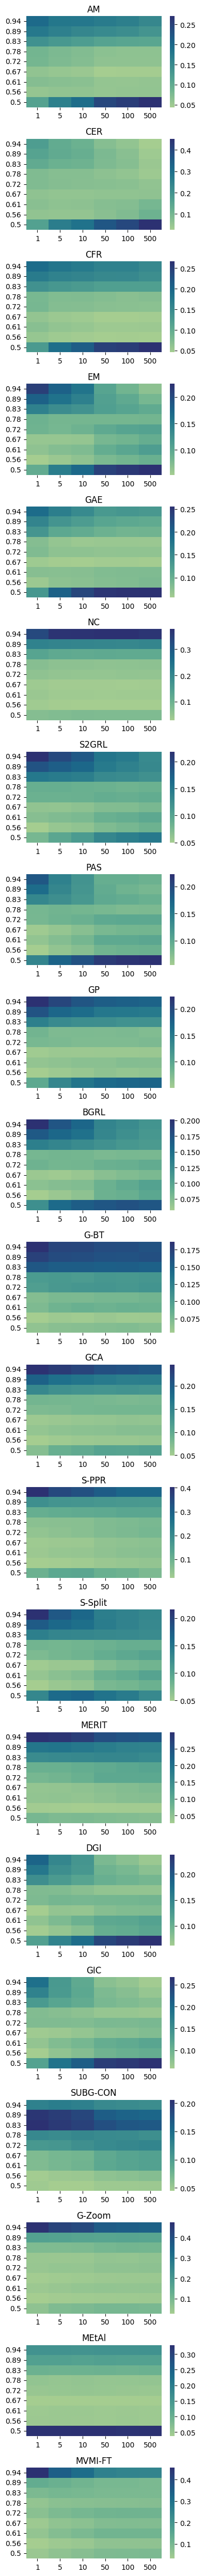

In [48]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

bins = np.linspace(0.5, 1.0, num=10).round(decimals=2)
_, axs = plt.subplots(nrows=len(SSL_MODELS), ncols=1, figsize=(4, 50))

model_positions = {}
encoder_positions = { encoder: i for i, encoder in enumerate(ENCODERS)}
idx = 0 
for ssl_cat in [GENERATION_ALL, AUXILIARY_ALL, CONTRAST_ALL, HYBRID_ALL]:
    for model in ssl_cat:
        model_positions[model] = idx
        idx += 1


df_ssl_jl.train_pretext_weight = df_ssl_jl.train_pretext_weight.astype(int)
train_pretext_weight_unique = df_ssl_jl.train_pretext_weight.unique()
train_pretext_weight_unique.sort()


for (model), df_all in df_ssl_jl.groupby(['SSL_model']):
    df_heat = pd.DataFrame(columns=train_pretext_weight_unique, index=np.flip(bins[:-1])).astype(float)
    for weight, df in df_all.groupby('train_pretext_weight'):
        bin_weights, bins_ = np.histogram(df[TEST_METRIC], bins=bins, density=False)
        bin_weights, bins_ = np.array(bin_weights) / len(df[TEST_METRIC]), np.array(bins_)[:-1]        
        for i, bin_value in enumerate(bins_):
            df_heat.loc[bin_value, weight] = bin_weights[i]
    ax = axs[model_positions[model]]
    sns.heatmap(
        data=df_heat,   
        cmap='crest', 
        ax=ax,
    )
    ax.set_title(f'{model_abbreviations[model]}')
plt.tight_layout()

/tmp/ipykernel_8625/2228866755.py:42: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')


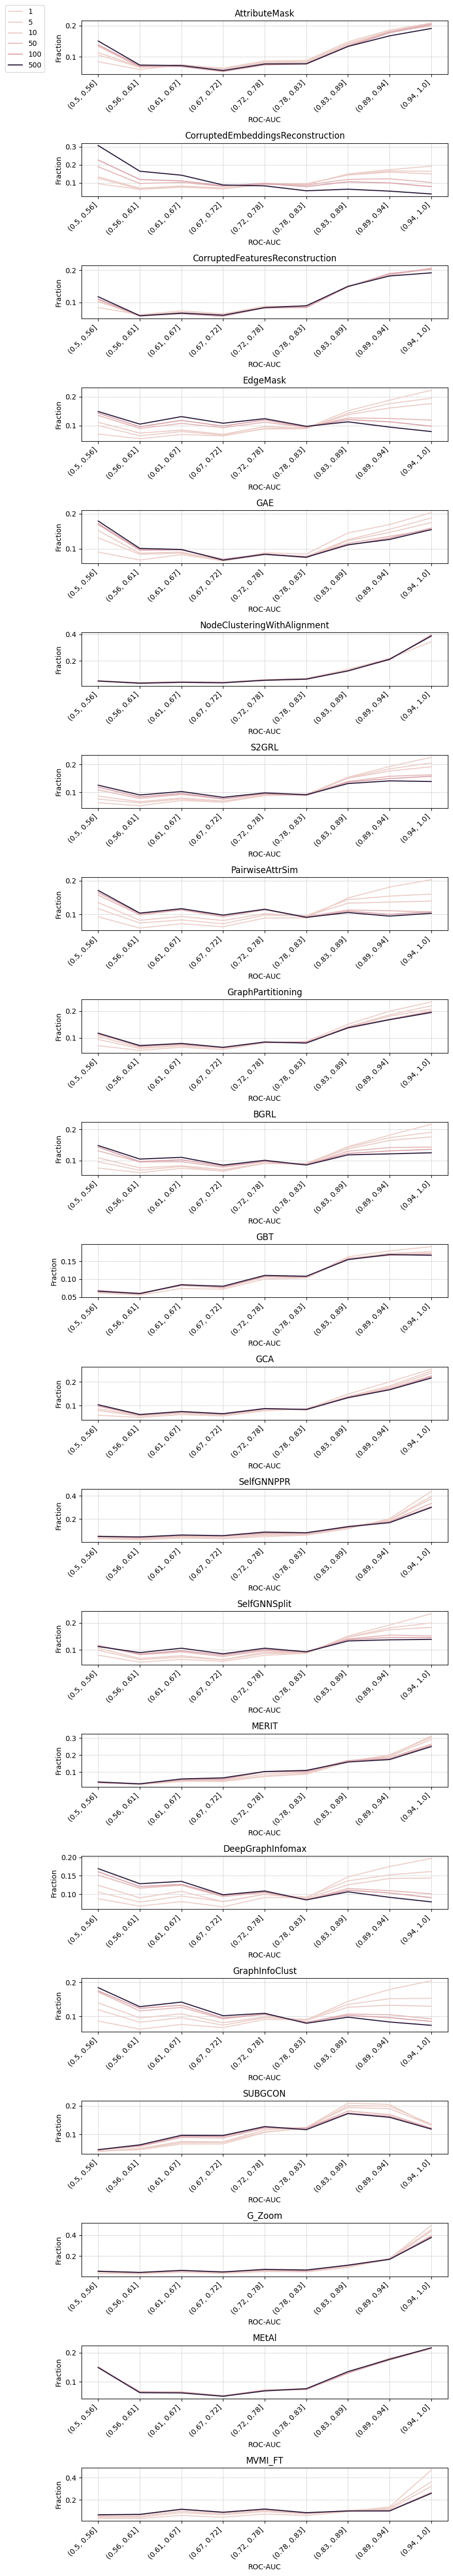

In [8]:
bins = np.linspace(0.5, 1.0, num=10).round(decimals=2)
_, axs = plt.subplots(nrows=len(SSL_MODELS), ncols=1, figsize=(8, 50))

model_positions = {}
encoder_positions = { encoder: i for i, encoder in enumerate(ENCODERS)}
idx = 0 
for ssl_cat in [GENERATION_ALL, AUXILIARY_ALL, CONTRAST_ALL, HYBRID_ALL]:
    for model in ssl_cat:
        model_positions[model] = idx
        idx += 1




for model, df_all in df_ssl_jl.groupby(['SSL_model']):
    results = []
    for key, v in df_all.groupby('train_pretext_weight'):
        bin_weights = pd.cut(v[TEST_METRIC], bins=bins).value_counts().reset_index().rename(columns={ 'index': 'ROC-AUC', TEST_METRIC: 'Fraction' })
        bin_weights['Fraction'] = bin_weights['Fraction'] / bin_weights['Fraction'].sum()
        bin_weights['train_pretext_weight'] = key
        results += [bin_weights]
    bin_df = pd.concat(results).reset_index()
    bin_df['ROC-AUC'] = bin_df['ROC-AUC'].apply(lambda x: f'({x.left}, {x.right}]')
    ax = axs[model_positions[model]]
    sns.lineplot(
        data=bin_df,
        x='ROC-AUC', 
        y='Fraction', 
        hue='train_pretext_weight',
        ax=ax
    )
    ax.legend().remove()  # Remove the default legend
    ax.set_title(model)  # Add the title of the model on each plot
    ax.yaxis.grid(True, linestyle='--', linewidth=0.5)  # Add horizontal gridlines
    ax.xaxis.grid(True, linestyle='--', linewidth=0.5)  # Add horizontal gridlines

handles, labels = axs[0].get_legend_handles_labels()
plt.figlegend(handles, labels, loc='upper left', bbox_to_anchor=(-0.1, 1.0))


for ax in axs:
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.tight_layout()

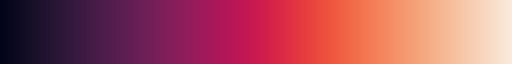

In [9]:
sns.color_palette("rocket", as_cmap=True, n_colors=6)

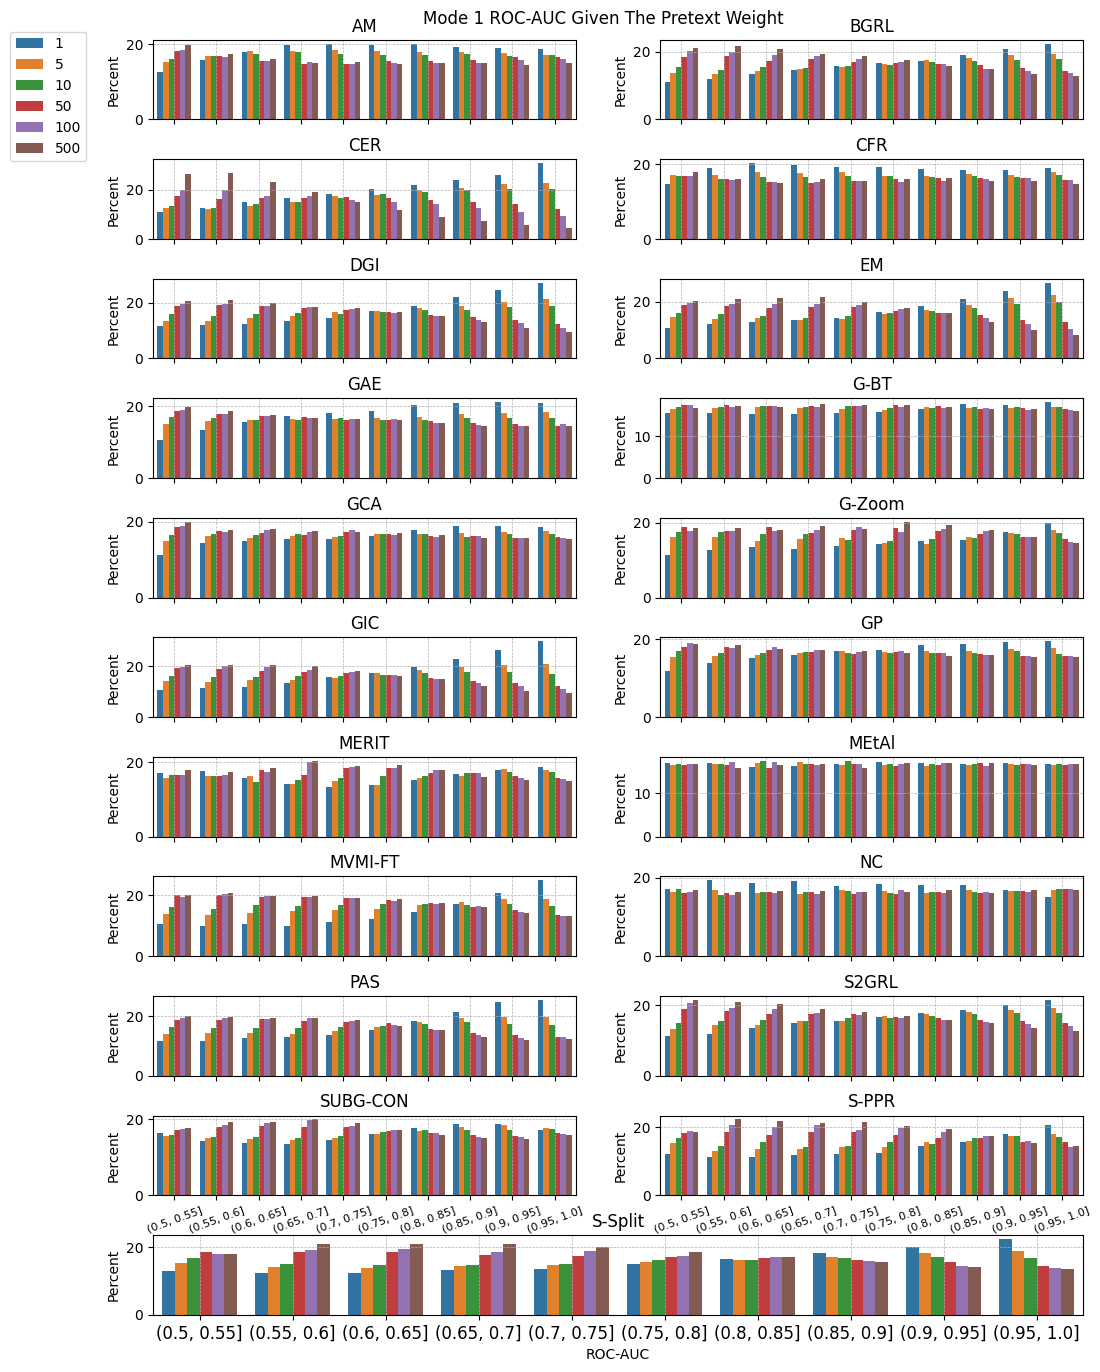

In [10]:
import math
bins = np.linspace(0.5, 1.0, num=11).round(decimals=2)
# fig, axs = plt.subplots(nrows=math.ceil(len(SSL_MODELS) / 2), ncols=2, figsize=(12, 25))
nrows, ncols = math.ceil(len(SSL_MODELS) / 2), 2
fig = plt.figure(figsize=(12, 15))
gs = gridspec.GridSpec(nrows, ncols, figure=fig, wspace=0.2, hspace=0.5)
axs = []


model_positions = {}
encoder_positions = { encoder: i for i, encoder in enumerate(ENCODERS)}
idx = 0 
for ssl_cat in [GENERATION_ALL, AUXILIARY_ALL, CONTRAST_ALL, HYBRID_ALL]:
    for model in ssl_cat:
        model_positions[model] = idx
        idx += 1
i = 0
for model, df_all in df_ssl_jl.groupby(['SSL_model']):
    if i == len(SSL_MODELS) - 1:
        ax = fig.add_subplot(gs[-1, :])  # Merge the cells in the last row
    else:
        ax = fig.add_subplot(gs[i // ncols, i % ncols])

    axs += [ax]
    result = (
        df_all
        .assign(test_rocauc_ovr=lambda df: np.where(df[TEST_METRIC] < 0.5, 0.5, df[TEST_METRIC]))
        .groupby('train_pretext_weight')
        .apply(lambda df: pd.cut(df[TEST_METRIC], bins=bins))
        .reset_index()
        .rename(columns={'train_pretext_weight': 'Pretext weight', TEST_METRIC: 'ROC-AUC'})
        .groupby(['ROC-AUC', 'Pretext weight'])
        .aggregate('count')
        .reset_index()
        .rename(columns={ 'level_1': 'Percent' })
    )

    bin_sums = result.groupby('ROC-AUC')['Percent'].sum().reset_index().rename(columns={ 'Percent': 'Sum' })
    result = pd.merge(left=result, right=bin_sums, on='ROC-AUC')
    result['Percent'] = 100 * (result['Percent'] / result['Sum'])
    result['ROC-AUC'] = result['ROC-AUC'].apply(lambda x: f'({x.left}, {x.right}]')

    sns.barplot(
        data=result,
        x='ROC-AUC', 
        y='Percent', 
        hue='Pretext weight',
        ax=ax,
    )
    ax.legend().remove()  # Remove the default legend
    ax.set_title(model_abbreviations[model])  # Add the title of the model on each plot
    ax.yaxis.grid(True, linestyle='--', linewidth=0.5)  # Add horizontal gridlines
    ax.xaxis.grid(True, linestyle='--', linewidth=0.5)  # Add horizontal gridlines
    if i // ncols != nrows - 1 and i // ncols != nrows - 2:
        ax.set_xticklabels([])
        ax.set_xlabel('')
    
    i += 1

handles, labels = axs[0].get_legend_handles_labels()
plt.figlegend(handles, labels, loc='upper left', bbox_to_anchor=(0, 0.97))


for ax in axs:
    ax.set_xticklabels(ax.get_xticklabels(), horizontalalignment='center', rotation=20, fontsize=8)
axs[-1].set_xticklabels(axs[-1].get_xticklabels(), horizontalalignment='center', rotation=0, fontsize=12)

fig.suptitle('Mode 1 ROC-AUC Given The Pretext Weight')
fig.subplots_adjust(top=0.96)


In [11]:
bins = np.linspace(0.49, 1.0, num=11).round(decimals=2)
result = (
    df_ssl_jl[df_ssl_jl['SSL_model'] == 'G_Zoom']
    .assign(test_rocauc_ovr=lambda df: np.where(df[TEST_METRIC] < 0.5, 0.5, df[TEST_METRIC]))
    .groupby('train_pretext_weight')
    .apply(lambda df: pd.cut(df[TEST_METRIC], bins=bins))
    .reset_index()
    .rename(columns={'train_pretext_weight': 'Pretext weight', TEST_METRIC: 'ROC-AUC'})
    .groupby(['ROC-AUC', 'Pretext weight'])
    .aggregate('count')
    .reset_index()
    .rename(columns={ 'level_1': 'Percent' })
)
result['Percent'] = result['Percent'] * 100 / result.groupby('ROC-AUC')['Percent'].transform('sum')


/tmp/ipykernel_8625/1385101622.py:42: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')


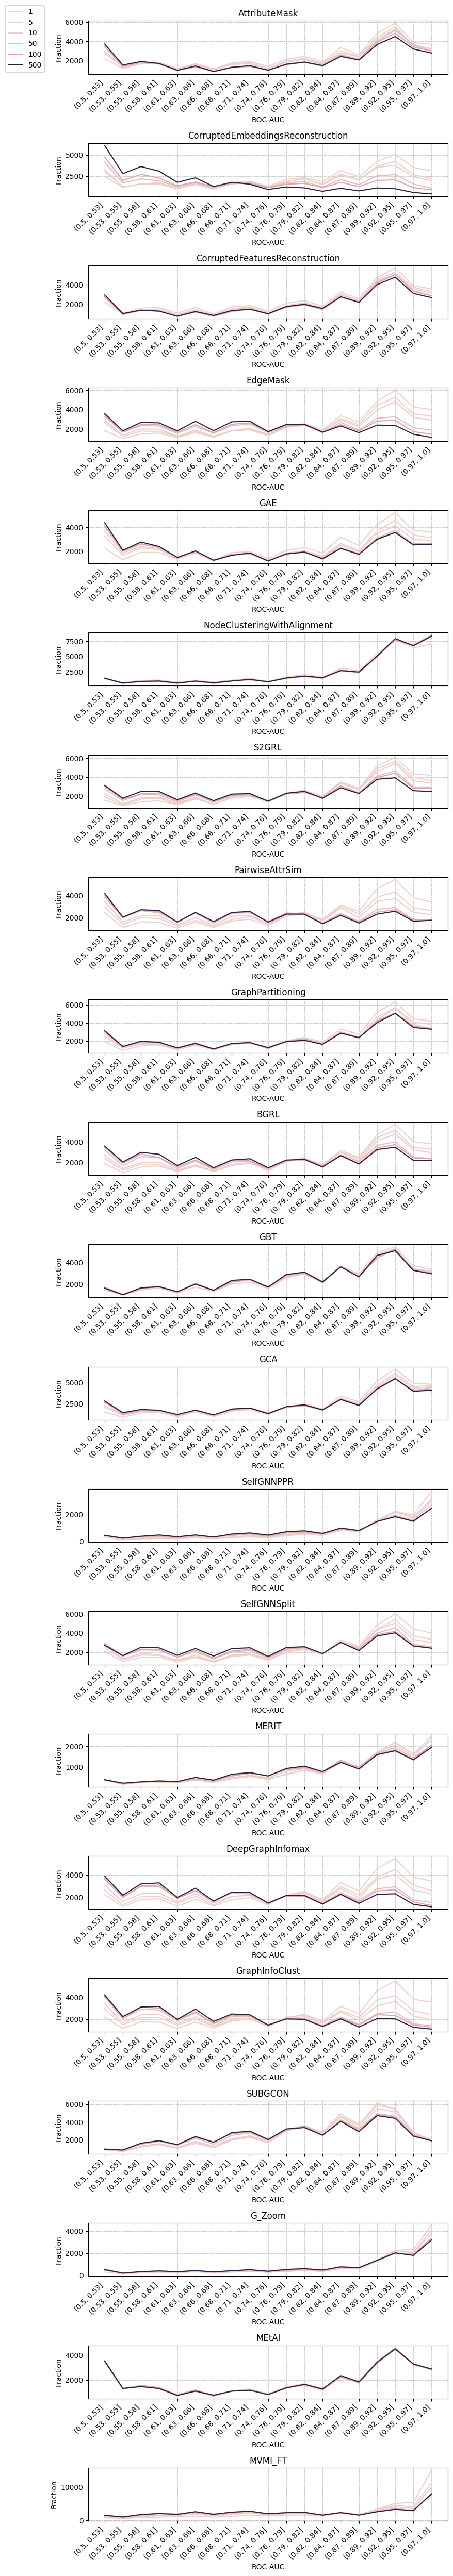

In [12]:
bins = np.linspace(0.5, 1.0, num=20).round(decimals=2)
_, axs = plt.subplots(nrows=len(SSL_MODELS), ncols=1, figsize=(8, 50))

model_positions = {}
encoder_positions = { encoder: i for i, encoder in enumerate(ENCODERS)}
idx = 0 
for ssl_cat in [GENERATION_ALL, AUXILIARY_ALL, CONTRAST_ALL, HYBRID_ALL]:
    for model in ssl_cat:
        model_positions[model] = idx
        idx += 1




for model, df_all in df_ssl_jl.groupby(['SSL_model']):
    results = []
    for key, v in df_all.groupby('train_pretext_weight'):
        bin_weights = pd.cut(v[TEST_METRIC], bins=bins).value_counts().reset_index().rename(columns={ 'index': 'ROC-AUC', TEST_METRIC: 'Fraction' })
        # bin_weights['Fraction'] = bin_weights['Fraction'] / bin_weights['Fraction'].sum()
        bin_weights['train_pretext_weight'] = key
        results += [bin_weights]
    bin_df = pd.concat(results).reset_index()
    bin_df['ROC-AUC'] = bin_df['ROC-AUC'].apply(lambda x: f'({x.left}, {x.right}]')
    ax = axs[model_positions[model]]
    sns.lineplot(
        data=bin_df,
        x='ROC-AUC', 
        y='Fraction', 
        hue='train_pretext_weight',
        ax=ax,
    )
    ax.legend().remove()  # Remove the default legend
    ax.set_title(model)  # Add the title of the model on each plot
    ax.yaxis.grid(True, linestyle='--', linewidth=0.5)  # Add horizontal gridlines
    ax.xaxis.grid(True, linestyle='--', linewidth=0.5)  # Add horizontal gridlines

handles, labels = axs[0].get_legend_handles_labels()
plt.figlegend(handles, labels, loc='upper left', bbox_to_anchor=(-0.1, 1.0))


for ax in axs:
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.tight_layout()

# Mode 1 and Mode 2/3 results

In [13]:
def print_latex_row(df_ssl_category_means, df_ssl_category_stds):
    for training_Scheme in ['PF', 'URL', 'JL']:
        for encoder in ['GCN', 'GAT', 'GIN']:
            if encoder not in df_ssl_category_means.Encoder.values:
                continue
            query = (df_ssl_category_means.Training_scheme == training_Scheme) & (df_ssl_category_means.Encoder == encoder)
            mean = df_ssl_category_means.loc[query, TEST_METRIC].values[0]
            std = df_ssl_category_stds.loc[query, TEST_METRIC].values[0]
            print(f'${mean:.2f}\pm{std:.2f}$ ', end='&')

def print_latex_table(experiment):
    for ssl_cat in [GENERATION_ALL, AUXILIARY_ALL, CONTRAST_ALL, HYBRID_ALL]:
        for model in ssl_cat:
            print(model)
            query = (df_ssl.SSL_model == model) & (df_ssl.Experiment == experiment)
            grp = df_ssl.loc[query].groupby(['Training_scheme', 'Encoder'])[TEST_METRIC]
            means, stds = grp.mean().reset_index(), grp.std().reset_index()
            print_latex_row(means, stds)
            print()

In [54]:
dff = df_ssl[df_ssl.Experiment == 'Mode 2/3'].groupby(['SSL_model', 'Encoder', 'Training_scheme'])[TEST_METRIC].agg(['mean', 'std']).reset_index()

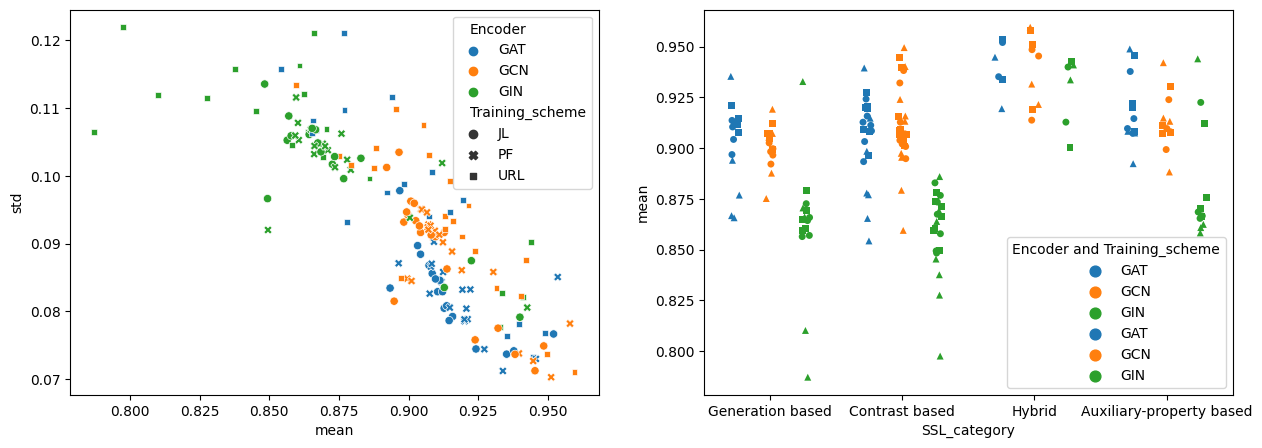

In [68]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
dff['SSL_category'] = dff['SSL_model'].apply(ssl_method_to_category)

# Create a dictionary to map the unique values of 'Training_scheme' to markers
unique_training_schemes = dff['Training_scheme'].unique()
marker_dict = {scheme: marker for scheme, marker in zip(unique_training_schemes, ['o', 's', '^', 'D', 'X'])}  # adjust markers as needed

sns.scatterplot(data=dff, x='mean', y='std', hue='Encoder', style='Training_scheme', ax=ax[0])

for training_scheme, marker in marker_dict.items():
    subset = dff[dff['Training_scheme'] == training_scheme]
    sns.stripplot(data=subset, x='SSL_category', y='mean', hue='Encoder', ax=ax[1], marker=marker, dodge=True)

# Optional: Fix legend title and labels
handles, labels = ax[1].get_legend_handles_labels()
ax[1].legend(handles[:len(unique_training_schemes) + len(dff['Encoder'].unique())], labels[:len(unique_training_schemes) + len(dff['Encoder'].unique())], title='Encoder and Training_scheme')

<AxesSubplot: xlabel='SSL_category', ylabel='mean'>

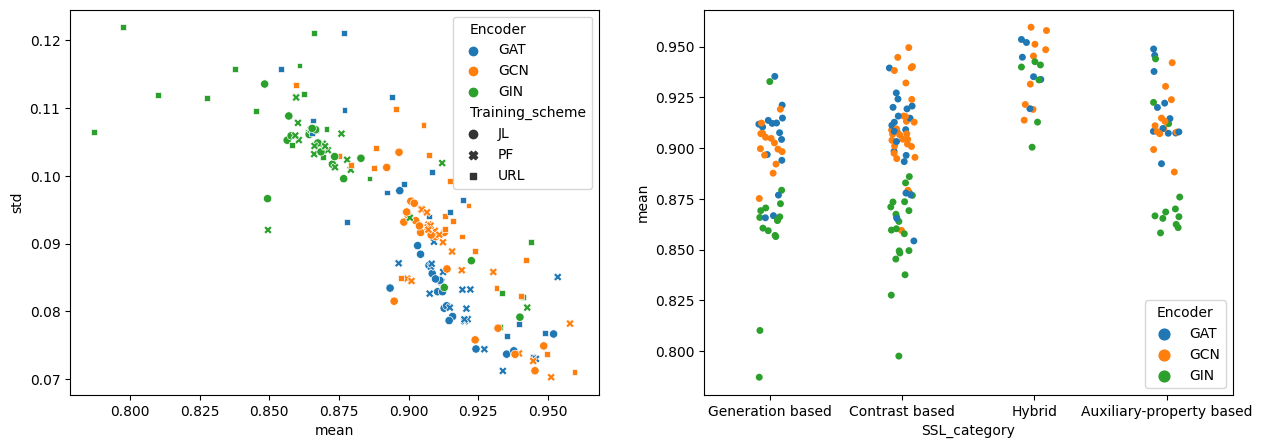

In [67]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
dff['SSL_category'] = dff['SSL_model'].apply(ssl_method_to_category)

sns.scatterplot(data=dff, x='mean', y='std', hue='Encoder', style='Training_scheme', ax=ax[0])
sns.stripplot(data=dff, x='SSL_category', y='mean', hue='Encoder' , ax=ax[1])

In [73]:
baseline_means = df_baseline.groupby(['Baseline_model'])[TEST_METRIC].agg(['mean']).reset_index()

In [100]:
ssl_cat_mean = df_ssl[df_ssl.Experiment == 'Mode 2/3'].groupby('SSL_category')[TEST_METRIC].mean().reset_index()

<AxesSubplot: xlabel='mean', ylabel='std'>

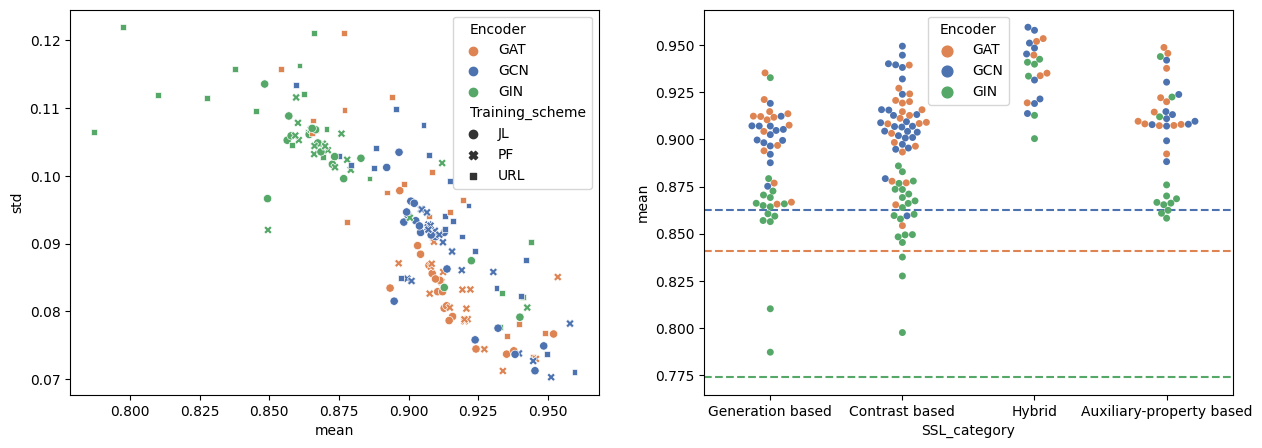

In [107]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
dff['SSL_category'] = dff['SSL_model'].apply(ssl_method_to_category)
ENCODER_COLORS = {
    'GCN': '#4C72B0',  # Blue
    'GAT': '#DD8452',  # Orange
    'GIN': '#55A868',  # Green
}


ax[1].axhline(y=baseline_means.loc[0]['mean'], linestyle='--', color=ENCODER_COLORS[baseline_means.loc[0]['Baseline_model']])
ax[1].axhline(y=baseline_means.loc[1]['mean'], linestyle='--', color=ENCODER_COLORS[baseline_means.loc[1]['Baseline_model']])
ax[1].axhline(y=baseline_means.loc[2]['mean'], linestyle='--', color=ENCODER_COLORS[baseline_means.loc[2]['Baseline_model']])

# ax[1].scatter(x=ssl_cat_mean['SSL_category'], y=ssl_cat_mean[TEST_METRIC], color='black', marker='x')
sns.swarmplot(data=dff, x='SSL_category', y='mean', hue='Encoder' , ax=ax[1], palette=ENCODER_COLORS)
sns.scatterplot(data=dff, x='mean', y='std', hue='Encoder', style='Training_scheme', ax=ax[0], palette=ENCODER_COLORS)

### Mode 1

In [14]:
print_latex_table('Mode 1')

AttributeMask
$0.85\pm0.14$ &$0.82\pm0.14$ &$0.76\pm0.14$ &$0.78\pm0.15$ &$0.79\pm0.14$ &$0.71\pm0.14$ &$0.78\pm0.18$ &$0.77\pm0.17$ &$0.71\pm0.17$ &
CorruptedEmbeddingsReconstruction
$0.84\pm0.14$ &$0.82\pm0.14$ &$0.75\pm0.14$ &$0.69\pm0.15$ &$0.72\pm0.15$ &$0.61\pm0.10$ &$0.71\pm0.18$ &$0.70\pm0.18$ &$0.64\pm0.15$ &
CorruptedFeaturesReconstruction
$0.85\pm0.14$ &$0.83\pm0.14$ &$0.76\pm0.14$ &$0.80\pm0.14$ &$0.81\pm0.14$ &$0.74\pm0.15$ &$0.79\pm0.18$ &$0.77\pm0.18$ &$0.70\pm0.17$ &
EdgeMask
$0.85\pm0.14$ &$0.82\pm0.14$ &$0.75\pm0.14$ &$0.77\pm0.14$ &$0.79\pm0.13$ &$0.67\pm0.12$ &$0.78\pm0.17$ &$0.76\pm0.17$ &$0.69\pm0.15$ &
GAE
$0.85\pm0.14$ &$0.82\pm0.15$ &$0.76\pm0.14$ &$0.79\pm0.15$ &$0.79\pm0.14$ &$0.70\pm0.14$ &$0.76\pm0.18$ &$0.74\pm0.18$ &$0.69\pm0.16$ &
NodeClusteringWithAlignment
$0.86\pm0.13$ &$0.83\pm0.14$ &$0.77\pm0.15$ &$0.84\pm0.13$ &$0.85\pm0.13$ &$0.79\pm0.15$ &$0.87\pm0.14$ &$0.85\pm0.15$ &$0.83\pm0.16$ &
S2GRL
$0.85\pm0.14$ &$0.82\pm0.14$ &$0.75\pm0.14$ &$0.79\pm0.14

In [15]:
print_latex_table('Mode 2/3')

AttributeMask
$0.90\pm0.08$ &$0.91\pm0.08$ &$0.87\pm0.10$ &$0.91\pm0.11$ &$0.89\pm0.11$ &$0.87\pm0.12$ &$0.89\pm0.10$ &$0.90\pm0.09$ &$0.87\pm0.11$ &
CorruptedEmbeddingsReconstruction
$0.91\pm0.09$ &$0.91\pm0.08$ &$0.86\pm0.11$ &$0.88\pm0.10$ &$0.87\pm0.11$ &$0.79\pm0.11$ &$0.90\pm0.09$ &$0.91\pm0.08$ &$0.86\pm0.11$ &
CorruptedFeaturesReconstruction
$0.91\pm0.09$ &$0.92\pm0.08$ &$0.88\pm0.10$ &$0.92\pm0.09$ &$0.94\pm0.08$ &$0.93\pm0.08$ &$0.90\pm0.09$ &$0.91\pm0.08$ &$0.87\pm0.10$ &
EdgeMask
$0.91\pm0.09$ &$0.91\pm0.08$ &$0.86\pm0.11$ &$0.89\pm0.10$ &$0.87\pm0.11$ &$0.81\pm0.11$ &$0.90\pm0.09$ &$0.91\pm0.08$ &$0.86\pm0.11$ &
GAE
$0.90\pm0.10$ &$0.91\pm0.09$ &$0.86\pm0.11$ &$0.91\pm0.10$ &$0.88\pm0.12$ &$0.87\pm0.11$ &$0.90\pm0.10$ &$0.90\pm0.10$ &$0.86\pm0.11$ &
NodeClusteringWithAlignment
$0.93\pm0.09$ &$0.95\pm0.07$ &$0.91\pm0.10$ &$0.94\pm0.09$ &$0.95\pm0.08$ &$0.94\pm0.09$ &$0.92\pm0.08$ &$0.94\pm0.07$ &$0.92\pm0.09$ &
S2GRL
$0.91\pm0.09$ &$0.91\pm0.09$ &$0.87\pm0.10$ &$0.91\pm0.09

In [16]:
df_baseline[df_baseline.Experiment == 'Mode 2/3'].groupby('Baseline_model')[TEST_METRIC].agg(['mean', 'std']).reset_index().round({ 'mean': 2, 'std': 2})

,Baseline_model,mean,std
0,GAT,0.90,0.09
1,GCN,0.90,0.09
2,GIN,0.86,0.11


In [17]:
df_ssl[df_ssl.Experiment == 'Mode 2/3'].dtypes

test_rocauc_ovr             float64
train_downstream_lr         float64
train_pretext_weight       category
train_pretext_epochs         object
train_pretext_lr            float64
encoder_in_channels           int64
encoder_hidden_channels       int64
encoder_num_layers            int64
encoder_dropout             float64
encoder_heads                object
SSL_model                    object
SSL_category                 object
Encoder                      object
Training_scheme              object
Graph_ID                      int64
Experiment                   object
dtype: object

In [78]:
sns.scatterplot(df_ssl[df_ssl.Experiment == 'Mode 2/3'].groupby(['SSL_model', 'Training_scheme', 'Encoder']).agg('mean').reset_index(), x='Training_scheme', y='mean', hue='Encoder')

/home/daen/.conda/envs/scara/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


ValueError: Could not interpret value `mean` for parameter `y`

# Encoder results

In [49]:
grp = df_ssl.groupby(['SSL_category', 'Training_scheme', 'Encoder', 'Experiment'])
encoder_mean = grp[TEST_METRIC].mean().reset_index()
encoder_std = grp[TEST_METRIC].std().reset_index()

In [50]:
positions = {}
idx = 0
for scheme in TRAINING_SCHEMES:
    for encoder in ENCODERS:
        positions[f'{scheme}-{encoder}'] = idx
        idx += 0.35
    idx += 0.3



def adjust_axis(model_i, model, training_i, training_scheme, ax, inner_grid, fig):
    if training_i == 0:
            ax.set_ylabel(model_abbreviations[model], fontsize=8, fontweight='bold', rotation=0, labelpad=32)
    ax.set_xticks([])

    ax.set_yticks([0.6, 0.8, 1.0], minor=False)
    ax.set_yticks([0.5, 0.7, 0.9], minor=True)
    ax.set_yticklabels({0.6: '0.6', 0.8: '0.8', 1.0: '1.0'}, minor=False)



    # ax.set_yticklabels(['', '', 0.6, '', 0.8, '', 1.0])
    ax.set_ylim([0.45, 1.0])
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(True)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(True)



def plot_bars(df):
    MODELS = df.SSL_model.unique()
    fig = plt.figure(figsize=(6, len(MODELS) * 1.2))
    outer = gridspec.GridSpec(ncols=1, nrows=len(MODELS), wspace=0.8, hspace=0.2)

    # Model
    for model_i, model in enumerate(MODELS):
        model_df = df[df.SSL_model == model]
        ax = plt.Subplot(fig, outer[model_i])
        # Training scheme
        for training_i, training_scheme in enumerate(TRAINING_SCHEMES):
            model_training_df = model_df[model_df.Training_scheme == training_scheme]
            adjust_axis(model_i, model, training_i, training_scheme, ax, None, fig)
            
            ################################ Error plot ################################
            for encoder in ENCODERS:
                model_training_encoder_df = model_training_df[model_training_df.Encoder == encoder]
                if len(model_training_encoder_df) == 0:
                    continue
                mean = model_training_encoder_df[TEST_METRIC].mean()
                # std = model_training_encoder_df[TEST_METRIC].std()
                ci = np.abs(mean - model_training_encoder_df[TEST_METRIC].quantile(q=(1/4, 3/4)).to_numpy())
                pos = positions[f'{training_scheme}-{encoder}']
                bar_width = 0.3
                ax.bar(x=pos, height=mean, color=ENCODER_COLORS[encoder], yerr=np.array([ci]).T, capsize=5, align='edge', 
                        label=f'{mean:.2f}', width=bar_width)
                ax.text(pos + bar_width / 2, 0.46, f'{mean:.2f}', fontsize=8, va='bottom', ha='center', color='black')

            fig.add_subplot(ax)

    for ax in fig.get_axes():
        ax.set_xlim((min(positions.values()) - 0.1, max(positions.values()) + 0.8))

plot_bars(dat)

NameError: name 'dat' is not defined

/tmp/ipykernel_5085/3517688749.py:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ENCODERS)
/tmp/ipykernel_5085/3517688749.py:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ENCODERS)
/tmp/ipykernel_5085/3517688749.py:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ENCODERS)


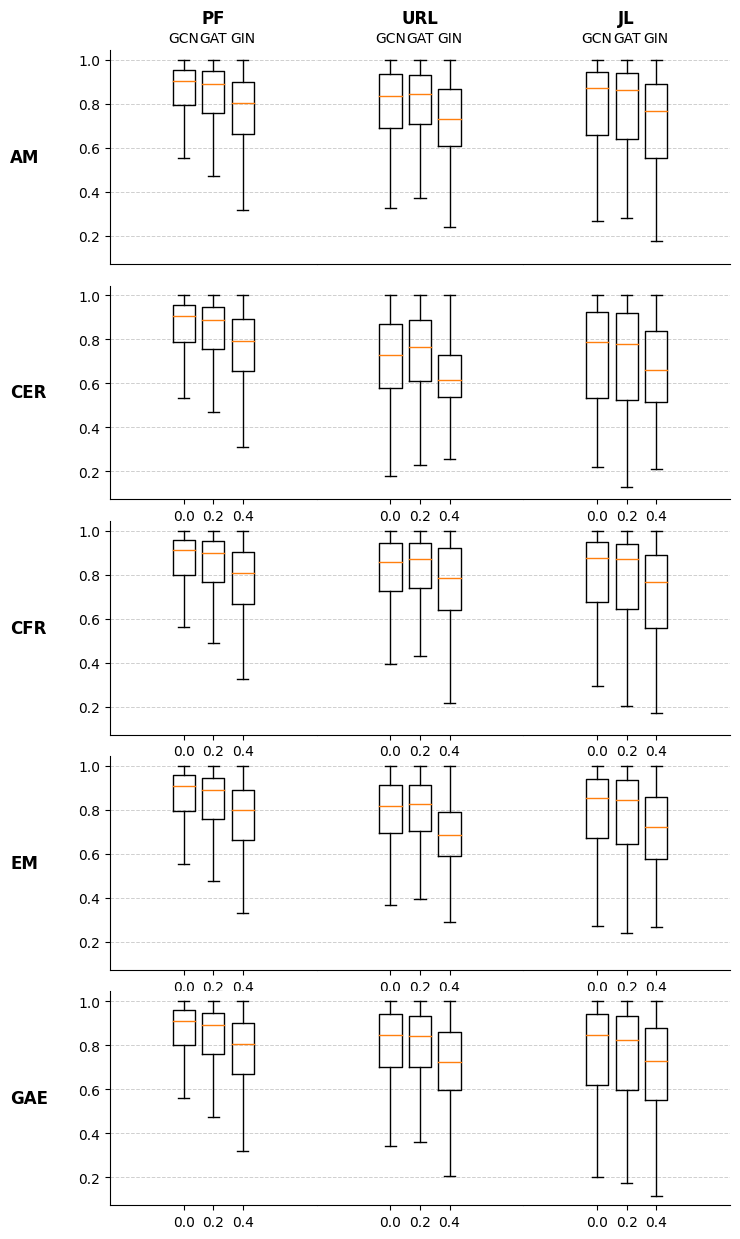

In [ ]:
def plot_bars(df):
    encoder_positions = { 'GCN': 0, 'GAT': 0.2, 'GIN': 0.4 }
    MODELS = df.SSL_model.unique()
    fig = plt.figure(figsize=(8, len(MODELS) * 3))
    outer = gridspec.GridSpec(nrows=len(MODELS), ncols=1, wspace=0, hspace=0.1)

    # Model
    for model_i, model in enumerate(MODELS):
        model_df = df[df.SSL_model == model]
        inner = gridspec.GridSpecFromSubplotSpec(nrows=1, ncols=3, subplot_spec=outer[model_i, 0], wspace=0, hspace=0)
        
        # Training scheme
        for training_i, training_scheme in enumerate(TRAINING_SCHEMES):
            model_training_df = model_df[model_df.Training_scheme == training_scheme]
            ax = plt.Subplot(fig, inner[training_i])
            ax.yaxis.grid(True, linestyle='--', linewidth=0.7, alpha=0.6)
            
            # Add a subtitle for the model
            if model_i == 0:
                ax.set_title(training_scheme, fontsize=12, fontweight='bold')
                ax.set_xticklabels(ENCODERS)
                ax.xaxis.tick_top()
                ax.tick_params(axis='x', length=0)
            else:
                ax.set_xticks([])
                ax.set_xticklabels([])
            

            if not (training_i == 0):
                ax.tick_params(axis='y', length=0)
                ax.set_yticklabels([])
                # ax.set_yticks([])
                ax.spines['left'].set_visible(False)
            else:
                ypos = inner[training_i].get_position(fig).y0 + 0.5 * inner[training_i].get_position(fig).height
                fig.text(0.00, ypos, model_abbreviations[model], fontweight='bold', fontsize=12, ha='left', va='center')
                
            ax.spines['top'].set_visible(False)
            ax.spines['bottom'].set_visible(True)
            ax.spines['right'].set_visible(False)


            data_points, positions, quantiles, medians = [], [], [], []
            # Encoder
            for encoder_i, encoder in enumerate(ENCODERS):
                model_training_encoder_df = model_training_df[model_training_df.Encoder == encoder]
   
                data_points += [model_training_encoder_df[TEST_METRIC]]
                positions += [encoder_positions[encoder]]


                

            ax.boxplot(data_points, notch=False, vert=True, showfliers=False, positions=positions)


            fig.add_subplot(ax)



    # Find the minimum and maximum x values across all subplots
    min_y, max_y = float('inf'), float('-inf')
    for ax in fig.get_axes():
        min_y = min(min_y, ax.get_ylim()[0])
        max_y = max(max_y, ax.get_ylim()[1])

    # Set the same x-axis limits across all subplots
    for ax in fig.get_axes():
        ax.set_ylim(min_y, max_y)
plot_bars(df_ssl[df_ssl.SSL_category == GENERATION_BASED_CATEGORY])